## Train celltypist for mouse gastrulation

In [12]:
import os,sys
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import scvelo.datasets

import celltypist

In [83]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import anndata2ri
anndata2ri.activate()

dirname: Trying to get version of get_version from dirname /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
dirname: Failed; Does not match re.compile('get[_-]version-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for get_version in dir /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
metadata: Succeeded
dirname: Trying to get version of anndata2ri from dirname /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
dirname: Failed; Does not match re.compile('anndata2ri-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for anndata2ri in dir /home/jovyan/my-cond

In [84]:
%load_ext rpy2.ipython

### Load datasets

In [3]:
data_dir = '/nfs/team205/ed6/data/mouse_gastrulation/'
adata_atlas = sc.read_h5ad(data_dir + 'MouseGastrulationAtlas.h5ad')

In [8]:
adata_atlas

AnnData object with n_obs × n_vars = 89267 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts'

### Train celltypist model

In [7]:
adata_atlas.layers['counts'] = adata_atlas.X.copy()

In [10]:
sc.pp.normalize_total(adata_atlas, target_sum=10000)
sc.pp.log1p(adata_atlas)

In [13]:
new_model = celltypist.train(adata_atlas, labels = 'celltype', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
✂️ 24634 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 3110 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [14]:
new_model.write(data_dir + 'MouseGastrulationAtlas.celltypist_model.pkl')

---
---

### Predict cell type labels

In [16]:
adata_ctrl = sc.read_h5ad(data_dir + 'WTChimera.h5ad')
adata_tal1 = sc.read_h5ad(data_dir + 'Tal1Chimera.h5ad')

In [19]:
adata_tal1.layers['counts'] = adata_tal1.X.copy()
adata_ctrl.layers['counts'] = adata_ctrl.X.copy()

In [26]:
adata_tal1.var_names = adata_tal1.var['SYMBOL'].values.astype('str')
adata_ctrl.var_names = adata_ctrl.var['SYMBOL'].values.astype('str')

In [20]:
sc.pp.normalize_total(adata_tal1, target_sum=10000)
sc.pp.log1p(adata_tal1)

In [27]:
predictions_tal1 = celltypist.annotate(adata_tal1, 
                                  model = data_dir + 'MouseGastrulationAtlas.celltypist_model.pkl', 
                        majority_voting = False)

🔬 Input data has 56122 cells and 29453 genes
🔗 Matching reference genes in the model
🧬 3058 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [29]:
sc.pp.normalize_total(adata_ctrl, target_sum=10000)
sc.pp.log1p(adata_ctrl)

In [30]:
predictions_ctrl = celltypist.annotate(adata_ctrl, 
                                  model = data_dir + 'MouseGastrulationAtlas.celltypist_model.pkl', 
                        majority_voting = False)

🔬 Input data has 30703 cells and 29453 genes
🔗 Matching reference genes in the model
🧬 3058 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


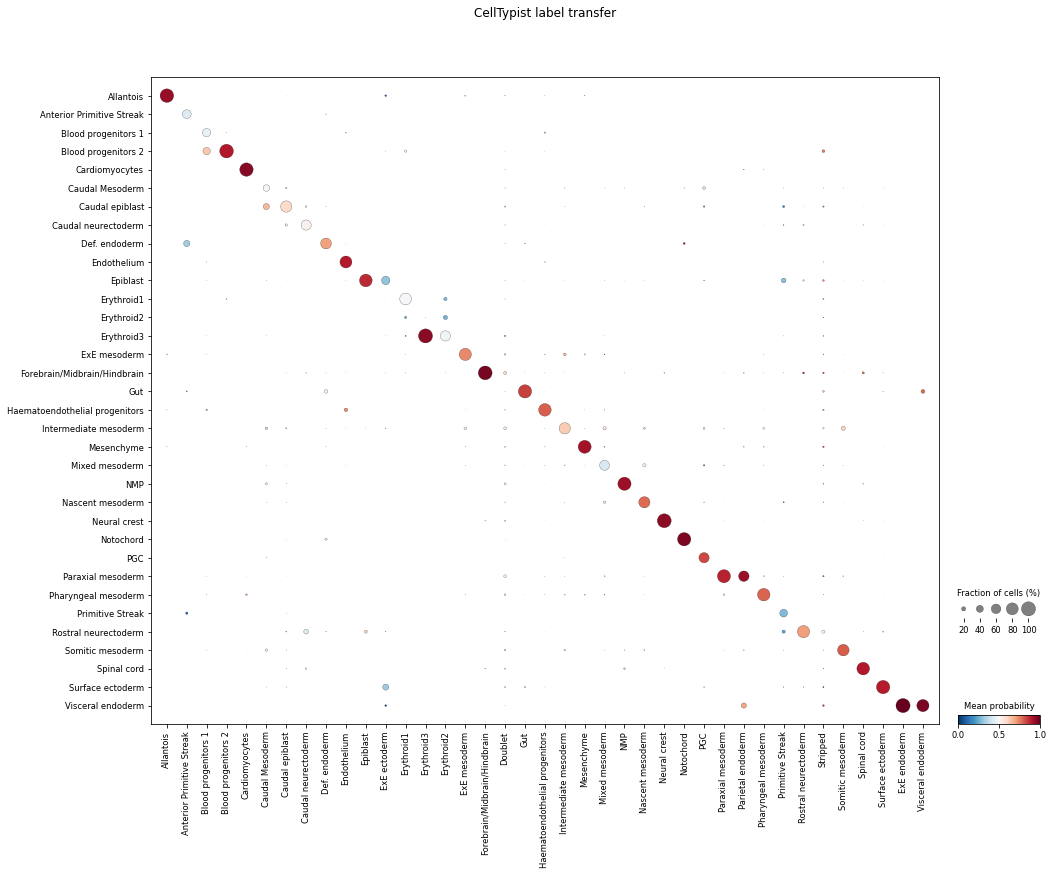

In [33]:
celltypist.dotplot(predictions_ctrl, use_as_reference = 'celltype.mapped', use_as_prediction = 'predicted_labels')

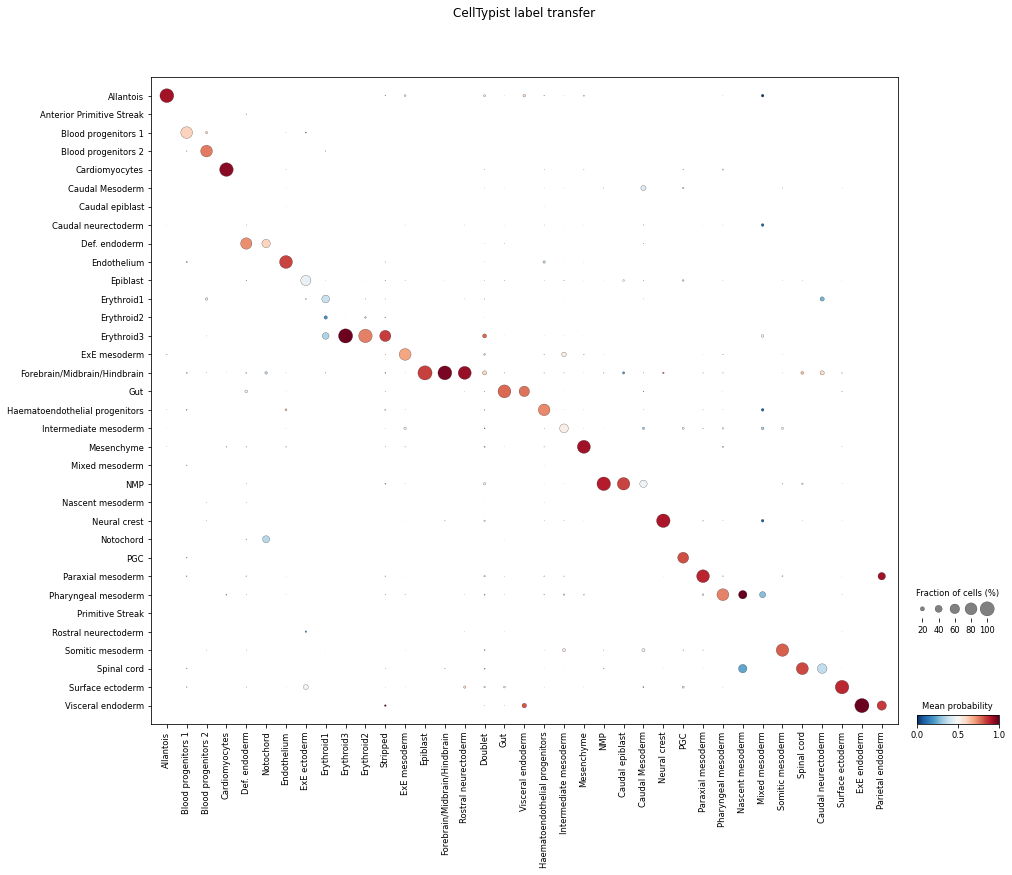

In [34]:
celltypist.dotplot(predictions_tal1, use_as_reference = 'celltype.mapped', use_as_prediction = 'predicted_labels')

In [60]:
adata_tal1 = predictions_tal1.to_adata()
adata_ctrl = predictions_ctrl.to_adata()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='None-tomato', ylabel='predicted_labels'>

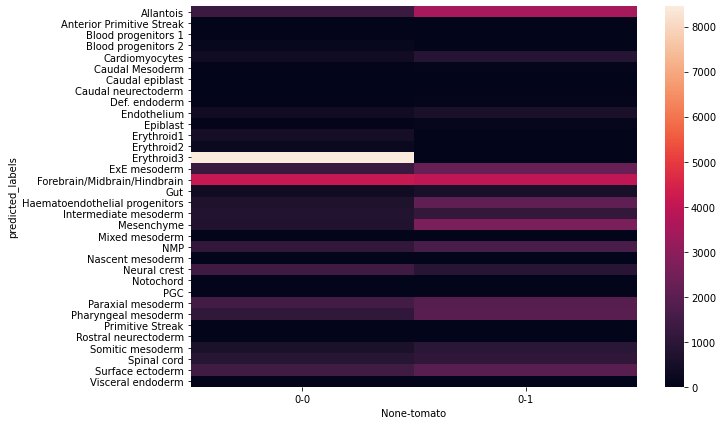

In [70]:
ct_counts_df = adata_tal1.obs[['tomato','predicted_labels']].value_counts().reset_index()\
.sort_values('predicted_labels').pivot(columns=['tomato'], index='predicted_labels')
ct_counts_df = ct_counts_df.fillna(0)

plt.rcParams['figure.figsize'] = [10,7]
sns.heatmap(ct_counts_df)

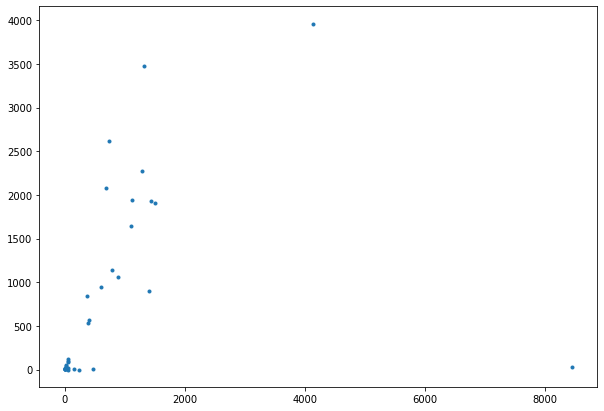

In [71]:
plt.plot(ct_counts_df[0][0], ct_counts_df[0][1], '.')

<AxesSubplot:xlabel='None-tomato', ylabel='predicted_labels'>

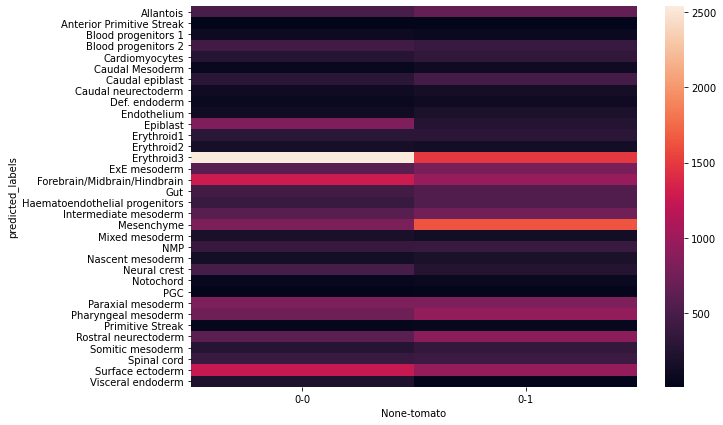

In [72]:
ct_counts_df = adata_ctrl.obs[['tomato','predicted_labels']].value_counts().reset_index()\
.sort_values('predicted_labels').pivot(columns=['tomato'], index='predicted_labels')
ct_counts_df = ct_counts_df.fillna(0)

plt.rcParams['figure.figsize'] = [10,7]
sns.heatmap(ct_counts_df)

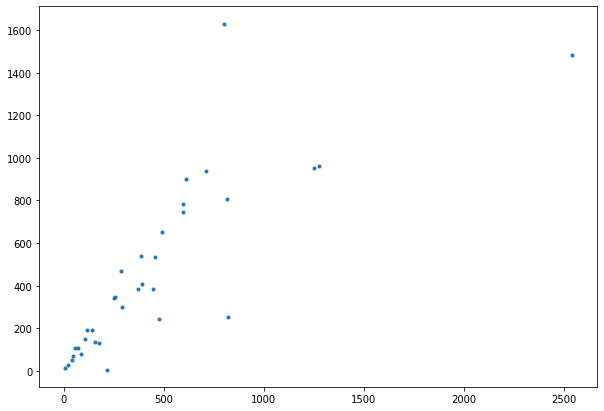

In [73]:
plt.plot(ct_counts_df[0][0], ct_counts_df[0][1], '.')

In [115]:
tal1_conf_df = adata_tal1.obs[['conf_score', 'tomato', 'sample', 'predicted_labels', 'celltype.mapped']]
tal1_conf_df['chimera'] = 'Tal1'
ctrl_conf_df = adata_ctrl.obs[['conf_score', 'tomato', 'sample', 'predicted_labels', 'celltype.mapped']]
ctrl_conf_df['chimera'] = 'WT'

conf_df = pd.concat([tal1_conf_df, ctrl_conf_df])

In [116]:
%%R -i conf_df
head(conf_df)

  conf_score tomato sample             predicted_labels
1 0.99955889      1      1 Forebrain/Midbrain/Hindbrain
2 0.99640763      1      1 Forebrain/Midbrain/Hindbrain
3 0.89735026      1      1            Paraxial mesoderm
4 0.70773563      1      1                 ExE mesoderm
5 0.06867427      1      1          Pharyngeal mesoderm
6 0.98624814      1      1               Cardiomyocytes
               celltype.mapped chimera
1 Forebrain/Midbrain/Hindbrain    Tal1
2         Rostral neurectoderm    Tal1
3            Paraxial mesoderm    Tal1
4                 ExE mesoderm    Tal1
5            Paraxial mesoderm    Tal1
6               Cardiomyocytes    Tal1


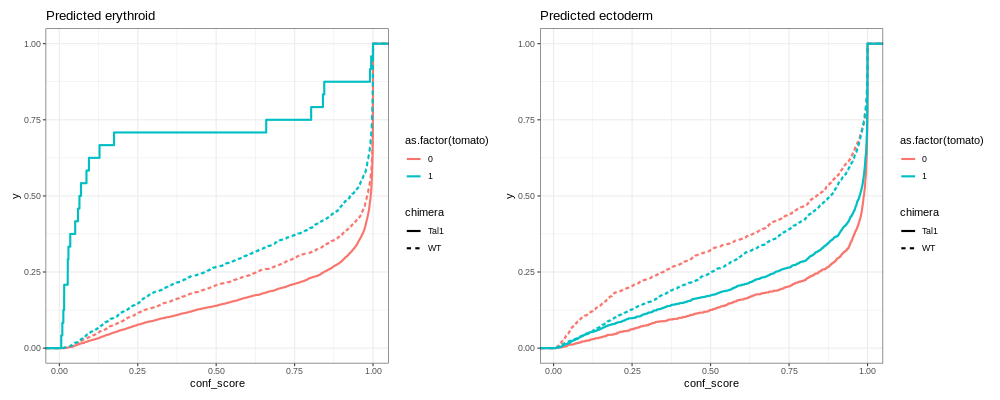

In [121]:
%%R -w 1000 -h 400
library(tidyverse)
library(patchwork)

conf_df %>%
    filter(str_detect(predicted_labels, "Ery")) %>%
    ggplot(aes(conf_score, color=as.factor(tomato), linetype=chimera)) +
    stat_ecdf(size=1) +
    theme_bw() +
    ggtitle("Predicted erythroid") +
    
conf_df %>%
    filter(str_detect(predicted_labels, "ectoderm")) %>%
    ggplot(aes(conf_score, color=as.factor(tomato), linetype=chimera)) +
    stat_ecdf(size=1) +
    theme_bw() +
    ggtitle("Predicted ectoderm") 

### Differential uncertainty analysis

In [125]:
import diff2atlas

In [207]:
adata_merged = adata_ctrl.concatenate(adata_tal1, batch_key='chimera', batch_categories=['Tal1+', "Tal1-"])
tomato_dict = {1:'KO', 0:'WT'}
adata_merged.obs['tomato_label'] = [tomato_dict[x] for x in adata_merged.obs['tomato']]

adata_merged.obs['sample_id'] = adata_merged.obs['chimera'].astype('str') + "_" + adata_merged.obs['tomato_label'] + "_sample" + adata_merged.obs['sample'].astype('str')
adata_merged.obs['KO'] = ((adata_merged.obs['tomato_label'] == 'KO') & (adata_merged.obs['chimera'] == 'Tal1-')).astype('int')
adata_merged.obs['KO'] = [tomato_dict[x] for x in adata_merged.obs['KO']]
adata_merged.obs['KO'] = adata_merged.obs['KO'].astype('category')

In [208]:
diff2atlas.make_cell_nhoods(adata_merged, method='clusters', clusters_key='predicted_labels')

In [209]:
diff2atlas.nhood_confidence(adata_merged, confidence_col='conf_score', sample_col='sample_id')
diff2atlas.make_design(adata_merged, categorical_covariates=['chimera', 'tomato_label','KO'])

In [210]:
diff2atlas.test_confidence(adata_merged, test_covariate='KO', method='AUROC')

In [211]:
model_mat = adata_merged.uns['nhood_adata'].varm['design_matrix'].copy()
model_mat = model_mat.astype('float') 

In [212]:
model_mat

,chimera_Tal1+,chimera_Tal1-,tomato_label_KO,tomato_label_WT,KO_KO,KO_WT
Tal1+_KO_sample1,1.0,0.0,1.0,0.0,0.0,1.0
Tal1+_KO_sample3,1.0,0.0,1.0,0.0,0.0,1.0
Tal1+_KO_sample5,1.0,0.0,1.0,0.0,0.0,1.0
Tal1+_KO_sample7,1.0,0.0,1.0,0.0,0.0,1.0
Tal1+_KO_sample9,1.0,0.0,1.0,0.0,0.0,1.0
Tal1+_WT_sample10,1.0,0.0,0.0,1.0,0.0,1.0
Tal1+_WT_sample2,1.0,0.0,0.0,1.0,0.0,1.0
Tal1+_WT_sample4,1.0,0.0,0.0,1.0,0.0,1.0
Tal1+_WT_sample6,1.0,0.0,0.0,1.0,0.0,1.0
Tal1+_WT_sample8,1.0,0.0,0.0,1.0,0.0,1.0


In [214]:
clusters_key = 'predicted_labels'
clusters = adata_merged.obs[clusters_key]


In [215]:
adata_merged.uns['nhood_adata'].obs_names = pd.get_dummies(clusters).columns
adata_merged.uns['nhood_adata'].obs.sort_values('confidence_test_statistic')

,confidence_test_statistic
Anterior Primitive Streak,0.291667
Primitive Streak,0.291667
Nascent mesoderm,0.416667
Somitic mesoderm,0.458333
Visceral endoderm,0.500000
Mixed mesoderm,0.500000
NMP,0.500000
Forebrain/Midbrain/Hindbrain,0.500000
Paraxial mesoderm,0.541667
PGC,0.583333


In [218]:
import milopy.utils  
adata_merged.obsm['nhoods'] = adata_merged.obsm['cell_nhoods'].copy()
milopy.utils.annotate_nhoods_continuous(adata_merged, anno_col='conf_score')

In [233]:
conf_mat = adata_merged.uns['nhood_adata'].layers['confidence']
adata_merged.uns['nhood_adata'].obs['pa_design_unc'] = 1 - conf_mat[:,adata_merged.uns['nhood_adata'].var['KO'] == 'KO'].mean(1)

In [234]:
df = adata_merged.uns['nhood_adata'].obs

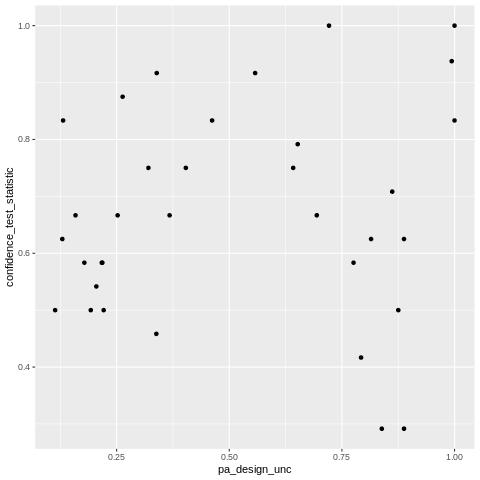

In [235]:
%%R -i df
df %>%
    ggplot(aes(pa_design_unc, confidence_test_statistic)) +
    geom_point()

In [237]:
df.sort_values('confidence_test_statistic')

,confidence_test_statistic,nhood_conf_score,pa_design_unc
Anterior Primitive Streak,0.291667,0.342483,0.887893
Primitive Streak,0.291667,0.261868,0.838568
Nascent mesoderm,0.416667,0.648582,0.792506
Somitic mesoderm,0.458333,0.681805,0.338161
Visceral endoderm,0.500000,0.711341,0.192640
Mixed mesoderm,0.500000,0.409967,0.875227
NMP,0.500000,0.798917,0.221254
Forebrain/Midbrain/Hindbrain,0.500000,0.902484,0.113509
Paraxial mesoderm,0.541667,0.816417,0.204988
PGC,0.583333,0.774964,0.217088
